In [10]:
import json
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import matplotlib.pyplot as plt
NB_DIR = Path().resolve()
ROOT = NB_DIR.parent
print(ROOT)

C:\Users\jleto\Projects\rev-vision


In [ ]:
import cv2
import json
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset

class LaneLineDataset(Dataset):
    def __init__(self, root, target_w=720, target_h=900, num_pts=5):
        self.root = Path(root)
        self.target_w = target_w
        self.target_h = target_h
        self.jsons = sorted(self.root.glob("*.json"))
        self.num_pts = num_pts 

    def __len__(self):
        return len(self.jsons)

    def __getitem__(self, idx):
        jpath = self.jsons[idx]
        with open(jpath) as f:
            data = json.load(f)

        img_path = self.root / data["imagePath"]
        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h0, w0 = img.shape[:2]
        
        img = cv2.resize(img, (self.target_w, self.target_h))
        img_tensor = torch.from_numpy(img.astype(np.float32) / 255.0).permute(2, 0, 1)

        # Mask at backbone resolution (113x90)
        mask_h, mask_w = 113, 90
        mask = np.zeros((mask_h, mask_w), dtype=np.float32)
        
        # Default targets to -1.0 (will be masked out in loss)
        targets = np.full((self.num_pts * 2, 2), -1.0, dtype=np.float32)

        for shape in data["shapes"]:
            pts = np.array(shape["points"], dtype=np.float32)
            
            # Draw Thick Mask (Thickness = 5)
            mask_pts = pts.copy()
            mask_pts[:, 0] *= (mask_w / w0)
            mask_pts[:, 1] *= (mask_h / h0)
            cv2.polylines(mask, [mask_pts.astype(np.int32)], False, 1, thickness=5)

            # Normalize Points
            pts[:, 0] /= w0
            pts[:, 1] /= h0
            top, bottom = pts[np.argmin(pts[:, 1])], pts[np.argmax(pts[:, 1])]
            line_pts = np.linspace(top, bottom, self.num_pts)

            if shape["label"] == "left":
                targets[:self.num_pts] = line_pts
            elif shape["label"] == "right":
                targets[self.num_pts:] = line_pts

        return img_tensor, torch.from_numpy(targets), torch.from_numpy(mask).unsqueeze(0)

In [12]:
from pathlib import Path

data_path = Path(ROOT / "data/gutter_regressor/new")
print("JSON count:", len(list(data_path.glob("*.json"))))
print("Files:", list(data_path.iterdir()))

JSON count: 97
Files: [WindowsPath('C:/Users/jleto/Projects/rev-vision/data/gutter_regressor/new/frame_0000.json'), WindowsPath('C:/Users/jleto/Projects/rev-vision/data/gutter_regressor/new/frame_0000.png'), WindowsPath('C:/Users/jleto/Projects/rev-vision/data/gutter_regressor/new/frame_0001.json'), WindowsPath('C:/Users/jleto/Projects/rev-vision/data/gutter_regressor/new/frame_0001.png'), WindowsPath('C:/Users/jleto/Projects/rev-vision/data/gutter_regressor/new/frame_0002.json'), WindowsPath('C:/Users/jleto/Projects/rev-vision/data/gutter_regressor/new/frame_0002.png'), WindowsPath('C:/Users/jleto/Projects/rev-vision/data/gutter_regressor/new/frame_0003.json'), WindowsPath('C:/Users/jleto/Projects/rev-vision/data/gutter_regressor/new/frame_0003.png'), WindowsPath('C:/Users/jleto/Projects/rev-vision/data/gutter_regressor/new/frame_0004.json'), WindowsPath('C:/Users/jleto/Projects/rev-vision/data/gutter_regressor/new/frame_0004.png'), WindowsPath('C:/Users/jleto/Projects/rev-vision/data

In [13]:
ds = LaneLineDataset(data_path)
img, targets, mask = ds[0]  # Add 'mask' here

print("Image shape:", img.shape)    
print("Targets shape:", targets.shape)
print("Mask shape:", mask.shape)

Image shape: torch.Size([3, 900, 720])
Targets shape: torch.Size([10, 2])
Mask shape: torch.Size([1, 113, 90])


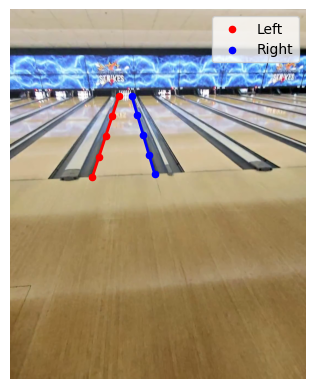

In [14]:
# Use the same num_pts as your Dataset class
num_pts = 5 

img_np = img.permute(1, 2, 0).numpy()
h, w = img_np.shape[:2]

pts = targets.numpy().copy()

pts[:, 0] *= w
pts[:, 1] *= h

plt.imshow(img_np)
plt.axis('scaled')

# Plot Left Line (first num_pts)
plt.scatter(pts[:num_pts, 0], pts[:num_pts, 1], c="red", s=20, label="Left")
plt.plot(pts[:num_pts, 0], pts[:num_pts, 1], "r-", linewidth=2)

# Plot Right Line (remaining num_pts)
plt.scatter(pts[num_pts:, 0], pts[num_pts:, 1], c="blue", s=20, label="Right")
plt.plot(pts[num_pts:, 0], pts[num_pts:, 1], "b-", linewidth=2)

plt.legend()
plt.axis("off")
plt.show()

In [ ]:
class LaneLineRegressor(nn.Module):
    def __init__(self, num_pts=5):
        super().__init__()
        self.num_pts = num_pts

        # 1. Backbone: Finds features
        self.backbone = nn.Sequential(
            CoordConv(3, 16, 3, stride=2, padding=1),   # 450x360
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),  # 225x180
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),  # 113x90
            nn.ReLU()
        )

        # 2. Heatmap Head: Outputs 10 channels (one for each point)
        # Instead of one big mask, each point gets its own 'spot'
        self.heatmap_head = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, num_pts * 2, 1), # 10 channels for 10 points
            nn.Sigmoid()
        )

    def forward(self, x):
        features = self.backbone(x)
        heatmaps = self.heatmap_head(features) # [B, 10, 113, 90]
        
        # 3. Coordinate Extraction (Soft-Argmax style)
        # We find the 'brightest' spot in each of the 10 heatmaps
        batch_size, channels, h, w = heatmaps.size()
        
        # Create grids for X and Y coordinates
        pos_y, pos_x = torch.meshgrid(torch.linspace(0, 1, h), torch.linspace(0, 1, w), indexing='ij')
        pos_y = pos_y.to(x.device).view(1, 1, h, w)
        pos_x = pos_x.to(x.device).view(1, 1, h, w)
        
        # Soft-argmax: Weight the grid positions by the heatmap intensity
        # We normalize heatmaps first so they sum to 1 spatially
        eps = 1e-6
        heatmaps_norm = heatmaps / (heatmaps.sum(dim=(2, 3), keepdim=True) + eps)
        
        expected_y = torch.sum(heatmaps_norm * pos_y, dim=(2, 3))
        expected_x = torch.sum(heatmaps_norm * pos_x, dim=(2, 3))
        
        # Stack to get [Batch, 10, 2]
        coords = torch.stack([expected_x, expected_y], dim=2)
        
        return coords, heatmaps.max(dim=1, keepdim=True)[0] # Return coords and a 'summary' mask

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SCALE = 0.75

ds = LaneLineDataset(data_path)
# loader = DataLoader(ds, batch_size=4, shuffle=True)
loader = DataLoader(ds, batch_size=1, shuffle=False)


model = LaneLineRegressor().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [79]:
# Setup
model = LaneLineRegressor(num_pts=5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion_coords = nn.MSELoss()
criterion_seg = nn.BCELoss()

epochs = 100

for epoch in range(epochs):
    model.train()
    total_loss = 0.0

    for imgs, targets, masks in loader:
        imgs, targets, masks = imgs.to(device), targets.to(device), masks.to(device)

        # Model now returns two things
        pred_coords, pred_mask = model(imgs)
        
        # Calculate dual loss
        loss_c = criterion_coords(pred_coords, targets)
        loss_s = criterion_seg(pred_mask, masks)
        
        # Combined loss (weighted so segmentation guides the learning)
        loss = loss_c + (0.1 * loss_s)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Epoch {epoch+1}/{epochs} | Total Loss: {avg_loss:.6f}")

    torch.save(model.state_dict(), "lane_regressor_hybrid.pt")

Epoch 1/100 | Total Loss: 0.069050
Epoch 2/100 | Total Loss: 0.063682
Epoch 3/100 | Total Loss: 0.059645
Epoch 4/100 | Total Loss: 0.057428
Epoch 5/100 | Total Loss: 0.057382
Epoch 6/100 | Total Loss: 0.055639
Epoch 7/100 | Total Loss: 0.056253
Epoch 8/100 | Total Loss: 0.051449
Epoch 9/100 | Total Loss: 0.039862
Epoch 10/100 | Total Loss: 0.038986
Epoch 11/100 | Total Loss: 0.025031
Epoch 12/100 | Total Loss: 0.023440
Epoch 13/100 | Total Loss: 0.016365


KeyboardInterrupt: 

C:\Users\jleto\AppData\Local\Temp\ipykernel_32636\1517918239.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("lane_regressor_hybrid.pt"

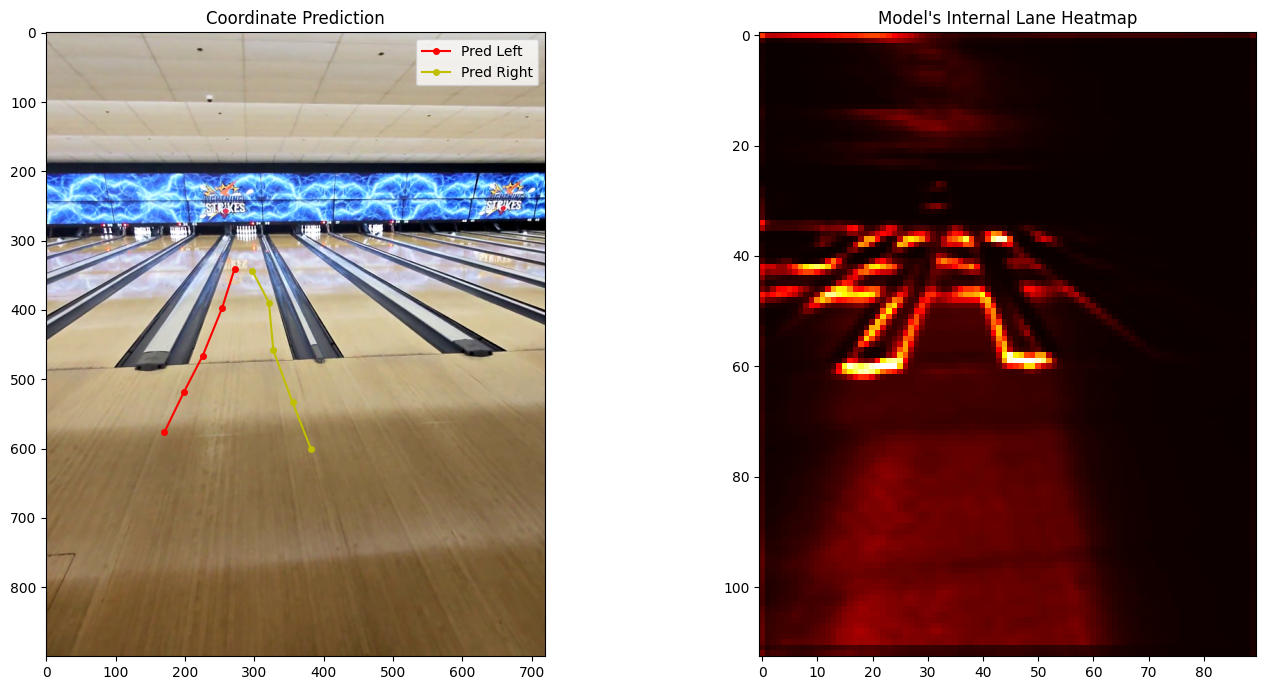

In [87]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random

# 1. Setup Device and Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LaneLineRegressor(num_pts=5).to(device)

# 2. Load the NEW weights (Make sure you trained with the new class first!)
model.load_state_dict(torch.load("lane_regressor_hybrid.pt", map_location=device))
model.eval()

# 3. Pick a random image from your dataset
i = random.randrange(len(ds))
img_tensor, targets, true_mask = ds[i]

# 4. Run Inference
with torch.no_grad():
    # Model expects [Batch, Channel, H, W]
    input_batch = img_tensor.unsqueeze(0).to(device)
    pred_lines, pred_mask = model(input_batch)

# 5. Prepare data for plotting
# Convert image tensor back to HWC for matplotlib
img_display = img_tensor.permute(1, 2, 0).numpy()
h, w = img_display.shape[:2]

# Move predictions to CPU and scale coordinates back to pixel values
pred_lines = pred_lines.squeeze(0).cpu().numpy() # [10, 2]
pred_lines[:, 0] *= w
pred_lines[:, 1] *= h

# Scale ground truth targets back to pixel values
true_lines = targets.cpu().numpy().copy()
true_lines[:, 0] *= w
true_lines[:, 1] *= h

# 6. Visualization
fig, ax = plt.subplots(1, 2, figsize=(15, 7))

# Plot 1: The Image + Predicted Lines
ax[0].imshow(img_display)
# Plot Predicted Left (First 5 pts)
ax[0].plot(pred_lines[:5, 0], pred_lines[:5, 1], 'ro-', label='Pred Left', markersize=4)
# Plot Predicted Right (Last 5 pts)
ax[0].plot(pred_lines[5:, 0], pred_lines[5:, 1], 'yo-', label='Pred Right', markersize=4)
ax[0].set_title("Coordinate Prediction")
ax[0].legend()

# Plot 2: The "Helper" Segmentation Mask
# This shows you exactly what the model's internal "spatial awareness" looks like
mask_display = pred_mask.squeeze().cpu().numpy()
ax[1].imshow(mask_display, cmap='hot')
ax[1].set_title("Model's Internal Lane Heatmap")

plt.tight_layout()
plt.show()

C:\Users\jleto\AppData\Local\Temp\ipykernel_21784\897022182.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("lane_regressor_latest.pt",

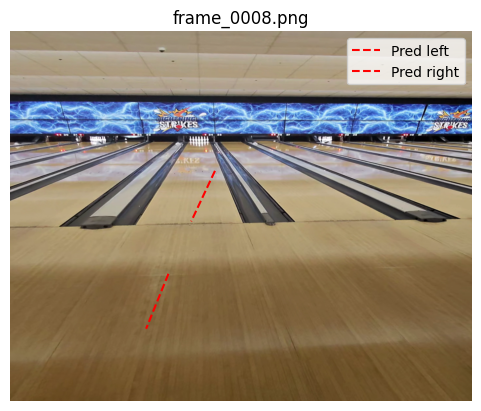

In [ ]:
from pathlib import Path
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torch

# --- config ---
IMAGE_DIR = Path(ROOT / "data/raw_frames/bowling6")  # change this
IMG_SIZE = (720, 900)  # training size

# --- model ---
model.load_state_dict(torch.load("lane_regressor_latest.pt", map_location=device))
model.eval()

# --- persistent index ---
if "img_idx" not in globals():
    img_idx = 0

img_paths = sorted(
    list(IMAGE_DIR.glob("*.png")) + list(IMAGE_DIR.glob("*.jpg"))
)

img_path = img_paths[img_idx]
img_idx = (img_idx + 1) % len(img_paths)

# --- preprocessing ---
transform = T.Compose([
    T.Resize(IMG_SIZE),
    T.ToTensor(),
])

img_pil = Image.open(img_path).convert("RGB")
img = transform(img_pil)

# --- inference ---
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device)).cpu()[0]

# --- plotting ---
img_np = img.permute(1, 2, 0).numpy()
h, w = img_np.shape[:2]

pred_pts = pred.numpy().copy()
pred_pts[:, 0] *= w
pred_pts[:, 1] *= h

plt.imshow(img_np)
plt.plot(pred_pts[0:2, 0], pred_pts[0:2, 1], "r--", label="Pred left")
plt.plot(pred_pts[2:4, 0], pred_pts[2:4, 1], "r--", label="Pred right")
plt.title(img_path.name)
plt.legend()
plt.axis("off")
plt.show()
